# Dowload of the ImageNet-A dataset

It containts images from 1000 classes, divided via folders

The download is done via Google Drive

In [ ]:
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This step is necessary to interact with Google Drive through PyDrive

# Authenticate the user with Google
auth.authenticate_user()
# Initialize GoogleAuth instance
gauth = GoogleAuth()
# Get default Google credentials
gauth.credentials = GoogleCredentials.get_application_default()
# Create GoogleDrive instance with authenticated credentials
drive = GoogleDrive(gauth)

# Define the file ID of the file to be downloaded from Google Drive
file_id = '1Fdx3kYLszDdYsBzqhfPYhfKUEXkFZbhW'

# Create a PyDrive file instance with the specified file ID
downloaded = drive.CreateFile({'id':file_id})

# Fetch metadata for the file, including title, size, and other details
downloaded.FetchMetadata(fetch_all=True)

# Download the file content to a local file with the same name as the file's title in Google Drive
downloaded.GetContentFile(downloaded.metadata['title'])


From the imagenet-a.tar file, extract the folders, each one containing images of a distinct class

In [ ]:
import tarfile

# Path to the downloaded .tar file (it's in the root)
tar_path = 'imagenet-a.tar'

# Extract the .tar file
with tarfile.open(tar_path) as file:
    # extract directly on the root folder
    file.extractall('')

From GitHub, get the list of human readable class ids

The position is indicative of the numerical id (position 0, id 0; position 1, id 1; and so on)

In [ ]:
import urllib.request
import json
# URL of the JSON file containing ImageNet labels
map_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Open the URL and read the response
response = urllib.request.urlopen(map_url)

# Decode the response to a string and load it as a JSON object
class_idx = json.loads(response.read().decode())


Download and extrapolate from Google Drive the file containing pairs of values, where the first one is the Imagenet-A id (folder name) and the second one is the equivalent human readable class labels

In [ ]:
# Define the file ID of the file to be downloaded from Google Drive.
file_id = '12pC8PjXAGOQAis8gCKZQzNyRw9Kn5bOb'

# Create a PyDrive file instance with the specified file ID.
file = drive.CreateFile({'id':file_id})

# Download the file's content to a local file named 'wordnet_to_class.txt'.
file.GetContentFile('wordnet_to_class.txt')


In [ ]:
# Initialize an empty dictionary to hold the class mappings.
class_mapping = {}

# Open the 'wordnet_to_class.txt' file in read mode.
with open("wordnet_to_class.txt", 'r') as f:
    # Read each line in the file.
    for line in f.readlines():
        # Split each line into parts using space as the delimiter.
        parts = line.strip().split(' ')
        # The first part is the class ID, and the rest is the class label.
        class_mapping[parts[0]] = ' '.join(parts[1:])

# Function to get the class label for a given class ID.
def get_class_label(class_id):
    # Return the class label if the class ID exists in the dictionary; otherwise, return "Unknownclass".
    return class_mapping.get(class_id, "Unknownclass")



# Instantiation of the ResNet-50 model

Then, is created a copy of the model parameters, since in the MEMO inference phase we are only allowed to evaluate each sample indipendently from the others, thus there is the necessity to reset the model's parameters after each prediction

For the model selection, we've followed the same one used in the MEMO paper (ResNet-50)

In [ ]:
import torch
from copy import deepcopy
from torchvision.models import resnet50, ResNet50_Weights

# Check if a GPU is available and use it; otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet-50 model with default weights
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

# Create a deep copy of the model's state dictionary (weights)
pesi_modello = deepcopy(model.state_dict())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


Some preprocessing steps are required, like having the image to be sent to the model, being of the resolution 224x224 (hard requirement of the ResNet-50 model)

This particular set of preprocessing steps, and their values, originate from the MEMO's implementation [page](https://github.com/zhangmarvin/memo), to align as best as possible to the official behaviour

In [ ]:
from torchvision import transforms

# Define the necessary transformations for the image preprocessing
preprocess = transforms.Compose([
    # Resize the image to 256x256 pixels
    transforms.Resize(256),
    # Crop the center of the image to 224x224 pixels
    transforms.CenterCrop(224),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the image with the mean values + standard deviation values for each channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


A function to load the images is defined, where automatically a conversion to RGB (the mode of operation of the ResNet-50 model) is applied, in combination with the preprocessing and single-item batch generation

In [ ]:
from PIL import Image

# Function to load and preprocess the image
def load_image(image_path):
    # Open the image and convert it to RGB
    input_image = Image.open(image_path).convert("RGB")
    # Apply preprocessing transformations
    input_tensor = preprocess(input_image)
    # Create a batch with a single image
    input_batch = input_tensor.unsqueeze(0)
    return input_batch


# ResNet-50 based prediction

Here, we make predictions on each sample by only utilizing the base ResNet-50 model, thus without MEMO or other improvements

Thus, a single foward pass will be utilized for each sample, checking the correctness of the prediction with an equality check on the human readable class labels (since we have {Imagenet-1K -> text} and {Imagenet-A -> text} mappings)


In [ ]:
import os
import tqdm

# Initialize the progress bar
pbar = tqdm.tqdm(range(7500))
model.eval()  # Set the model to evaluation mode
corretti = 0  # Counter for correct predictions

# Iterate through the images in the directory
for cartella in os.listdir("imagenet-a"):
    cartella_path = os.path.join("imagenet-a", cartella)

    if os.path.isdir(cartella_path):
        for filename in os.listdir(cartella_path):
          # Get the true label for the current folder
            true_label = get_class_label(cartella_path[-9:])
            # Check if the file is an image
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPEG"):
                image_path = os.path.join(cartella_path, filename)
                # Load and preprocess the image
                input_batch = load_image(image_path).to(device)

                # Make the prediction
                with torch.no_grad():
                    output = model(input_batch)

                    # The model returns 1000 values corresponding to ImageNet classes
                    # Get the index of the class with the highest probability
                    _, predicted_class = torch.max(output, 1)
                     # Check if the prediction is correct
                    if (class_idx[predicted_class.item()] == true_label):
                        corretti +=1
                    # Update the progress bar
                    pbar.update(1)
                    pbar.set_description("Correct: "+str(corretti))
            else:
                # print the name of the name of the foreign file
                print(filename)

Correct: 543: 100%|██████████| 7500/7500 [02:15<00:00, 64.69it/s]

# BASELINE MEMO


---


From there the implementation of the MEMO paper will start


The first necessary components to add are the the augmentations, and their corrispettive parameters, all derived from the MEMO's implementation [page](https://github.com/zhangmarvin/memo)

Respectively those are:

*   Auto contrast
*   Equalization
*   Rotation
*   Solarization
*   Shear on the x and y axis
*   Translation on the x and y axis
*   Posterization

Which will be randomly sampled from the Augmix function, to be applied to a randomly cropped resized image (32x32, see preaugment operation)

This function will define three different branches, where on each from 1 to 3 (included) augmentations will be applied. Augmix will then return the combined image from the three branches

In [ ]:
from PIL import ImageOps, Image
from torchvision.transforms import v2
import numpy as np

# Define a custom transformation class that returns the input image unchanged
class Identity:
    def __call__(self, img):
        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'

# Define the AugMix augmentation function
def augmix(image_path):
    # Open the image and convert to RGB
    x_orig = Image.open(image_path).convert("RGB")
    # Apply pre-augmentation transformations
    x_orig = preaugment(x_orig)
    # Apply preprocessing transformations
    x_processed = preprocess(x_orig)
    # Generate random weights and mixing factor
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    # Initialize a tensor to hold the mixed image
    mix = torch.zeros_like(x_processed)
    for i in range(3):
        # Copy the original image and apply random augmentations
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):
            x_aug = np.random.choice(augmentations)(x_aug)
        # Add the weighted augmented image to the mix
        mix += w[i] * preprocess(x_aug)
    # Combine the original and mixed images using the mixing factor
    mix = m * x_processed + (1 - m) * mix
    return mix

# Define various image augmentation functions
def autocontrast(pil_img, level=None):
    return ImageOps.autocontrast(pil_img)

def equalize(pil_img, level=None):
    return ImageOps.equalize(pil_img)

def rotate(pil_img, level):
    degrees = int_parameter(rand_lvl(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR, fillcolor=128)

def solarize(pil_img, level):
    level = int_parameter(rand_lvl(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)

def shear_x(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((32, 32), Image.AFFINE, (1, level, 0, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)

def shear_y(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((32, 32), Image.AFFINE, (1, 0, 0, level, 1, 0), resample=Image.BILINEAR, fillcolor=128)

def translate_x(pil_img, level):
    level = int_parameter(rand_lvl(level), 32 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((32, 32), Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)

def translate_y(pil_img, level):
    level = int_parameter(rand_lvl(level), 32 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((32, 32), Image.AFFINE, (1, 0, 0, 0, 1, level), resample=Image.BILINEAR, fillcolor=128)

def posterize(pil_img, level):
    level = int_parameter(rand_lvl(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)

# Helper functions for parameter scaling
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
        level: Level of the operation that will be between [0, `PARAMETER_MAX`].
        maxval: Maximum value that the operation can have. This will be scaled to level/PARAMETER_MAX.
    Returns:
        An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)

def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
        level: Level of the operation that will be between [0, `PARAMETER_MAX`].
        maxval: Maximum value that the operation can have. This will be scaled to level/PARAMETER_MAX.
    Returns:
        A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.

def rand_lvl(n):
    """Helper function to generate a random level value.
    Args:
        n: Maximum value for the random level.
    Returns:
        A float representing the random level.
    """
    return np.random.uniform(low=0.1, high=n)

# List of augmentation functions to be used
augmentations = np.array([
    autocontrast,
    equalize,
    lambda x: rotate(x, 1),
    lambda x: solarize(x, 1),
    lambda x: shear_x(x, 1),
    lambda x: shear_y(x, 1),
    lambda x: translate_x(x, 1),
    lambda x: translate_y(x, 1),
    lambda x: posterize(x, 1),
])

# Corresponding captions for the augmentations
captions = np.array([
    "autocontrast",
    "equalize",
    "rotate",
    "solarize",
    "shear_x",
    "shear_y",
    "translate_x",
    "translate_y",
    "posterize"
])

# Mean and standard deviation values for normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Define the preprocessing transformations
preprocess = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # ToTensor() is deprecated
    v2.Normalize(mean, std)
])

# Define the pre-augmentation transformations
preaugment = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
])


The marginal entrophy is then defined, because we can't use the labels during inference time to generate a loss

This method was written following the description on MEMO paper
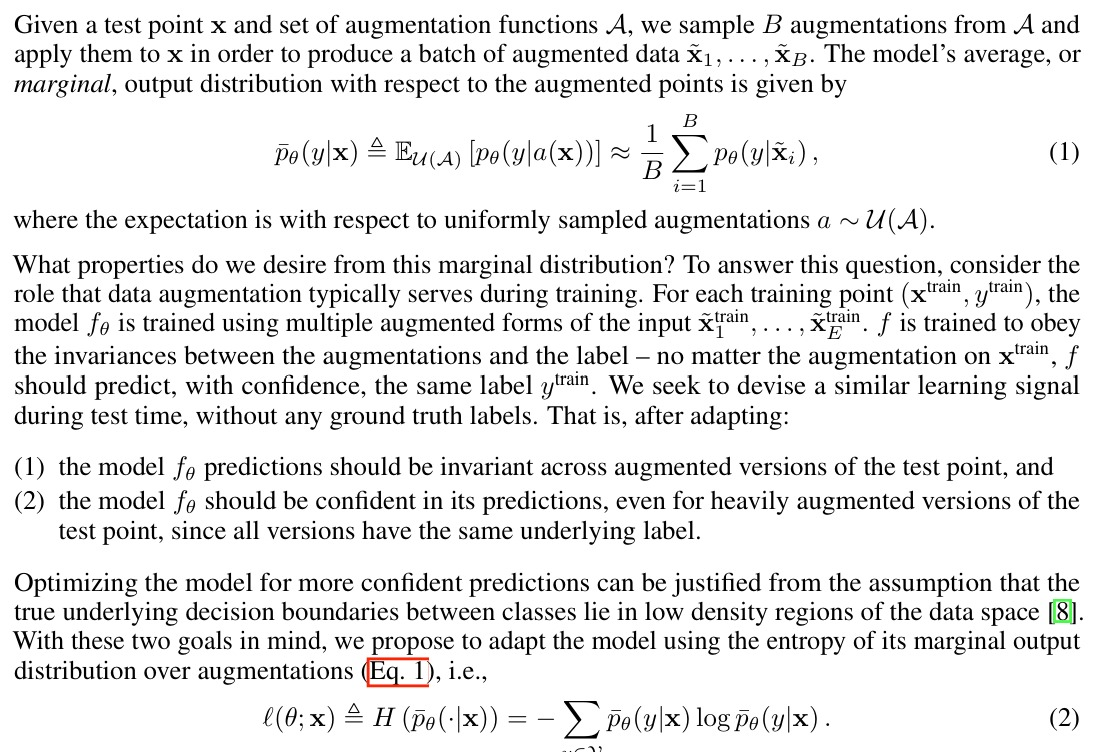

In [ ]:
# Function to calculate the marginal entropy (loss)
def marginal_entropy(outputs):
    # Normalize logits
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    # Calculate average logits
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    # Ensure logits do not go below the minimum real value
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    # Calculate entropy
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits

The same approach was followed to derive the batch normalization, and to choose the prior strenght (hyperparameter) value

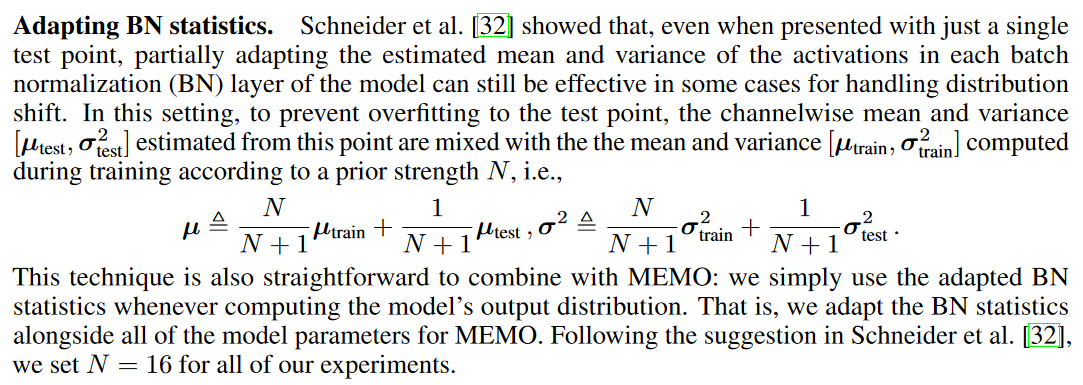

In [ ]:
import torch.nn as nn

# Define batch normalization layers for different stages of the model
batch_norm_layers = {
    'layer1': nn.BatchNorm2d(256).to(device),
    'layer2': nn.BatchNorm2d(512).to(device),
    'layer3': nn.BatchNorm2d(1024).to(device),
    'layer4': nn.BatchNorm2d(2048).to(device),
}

N = 16  # Prior strength, as suggested by the paper

# Define a forward hook to apply batch normalization
def forward_hook(module, input, output):
    if module in batch_norm_layers.values():
        # Find the corresponding batch normalization layer
        bn_layer = batch_norm_layers[next(key for key, value in batch_norm_layers.items() if value == module)]

        # Compute test statistics (mean and variance) for the output
        test_mean = output.mean([0, 2, 3])
        test_var = output.var([0, 2, 3], unbiased=False)

        # Update running statistics for batch normalization
        bn_layer.running_mean = (N / (N + 1)) * bn_layer.running_mean + (1 / (N + 1)) * test_mean
        bn_layer.running_var = (N / (N + 1)) * bn_layer.running_var + (1 / (N + 1)) * test_var

        # Apply the batch normalization layer to the output
        return bn_layer(output)
    return output

# Register forward hooks for the desired layers in the model
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
layers = [model.layer1, model.layer2, model.layer3, model.layer4]

for name, layer in zip(layer_names, layers):
    for sub_layer in layer:
        sub_layer.register_forward_hook(forward_hook)


Here, we make predictions on each sample by only utilizing the ResNet-50 model in combination with MEMO

On each sample, the steps followed are:

1.   One single pass will be done for each augmented version of the current sample. The number of augmentations is 64, as stated in the MEMO paper
2.   The marginal entrophy will be calculated, thus a loss on the distances based on the entropy
3.   A single backpropagation step, on the loss accumulated on each of the augmentations. For this a SGD optimizer was choosen, as stated on the paper, with learning rate 0.00025 (also stated inside the paper)
4. The final prediction for the current sample will be done, checking the correctness by assessing its true label (thus via the name of folder in which  the image is in)

In [ ]:
import torch.optim as optim
import tqdm
import os

# Initialize the progress bar
pbar = tqdm.tqdm(range(7500))
corretti = 0  # Counter for correct predictions
aug_num = 64  # Number of augmentations
optimizer = optim.SGD(model.parameters(), lr=0.00025)  # Optimizer for the model

# Iterate through the images in the directory
for cartella in os.listdir("imagenet-a"):
    cartella_path = os.path.join("imagenet-a", cartella)

    if os.path.isdir(cartella_path):
        for filename in os.listdir(cartella_path):
            # Get the true label for the current folder
            true_label = get_class_label(cartella_path[-9:])

            # Check if the file is an image
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPEG"):
                image_path = os.path.join(cartella_path, filename)

                # Load and preprocess the image
                input_batch = load_image(image_path).to(device)

                # Reset the model and optimizer
                model.load_state_dict(pesi_modello)
                optimizer.zero_grad()
                model.train()

                # Generate 64 different augmentations
                img_list = [augmix(image_path) for _ in range(aug_num)]
                img_list = torch.stack(img_list)
                # Make predictions for each augmentation
                outputs = model(img_list.to(device))
                # Calculate the loss using marginal entropy
                loss, avg_logits = marginal_entropy(outputs)

                # Backpropagation step and update the model
                loss.backward()
                optimizer.step()
                model.eval()

                # Make the final prediction on the current sample
                with torch.no_grad():
                    output = model(input_batch)

                    # The model returns 1000 values corresponding to ImageNet classes
                    # Get the index of the class with the highest probability
                    _, predicted_class = torch.max(output, 1)

                    # Check if the prediction is correct
                    if class_idx[predicted_class.item()] == true_label:
                        corretti += 1

                    # Update the progress bar
                    pbar.update(1)
                    pbar.set_description("Correct: " + str(corretti))
            else:
                print(filename)



  0%|          | 0/7500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Correct: 693: 100%|██████████| 7500/7500 [56:42<00:00,  2.42it/s]

# OUR WORK:

---

In this project, we focused on Test Time Adaptation to improve the performance of pre-trained models on new test data. The basic methodology was to start from the baseline provided by MEMO (Memory Efficient Meta-Optimisation) and then improve the approach by adding a block of SimCLR  [(Simple Framework for Contrastive Learning of Visual Representations)](https://arxiv.org/pdf/2002.05709).


> SimCLR is a contrastive learning framework for learning robust representations by comparing pairs of augmented images. By adding a block of SimCLR after the MEMO baseline, an attempt is made to further improve the model's ability to adapt to new test data by exploiting representations learned through contrastive comparison.



In [ ]:
from torchvision.transforms import v2
import numpy as np

# Define an array of augmentation functions
augmentations = np.array([
    autocontrast,
    equalize,
    lambda x: rotate(x, 1),
    lambda x: solarize(x, 1),
    lambda x: shear_x(x, 1),
    lambda x: shear_y(x, 1),
    lambda x: translate_x(x, 1),
    lambda x: translate_y(x, 1),
    lambda x: posterize(x, 1),
])
# Define corresponding captions for the augmentations
captions = np.array([
    "autocontrast",
    "equalize",
    "rotate",
    "solarize",
    "shear_x",
    "shear_y",
    "translate_x",
    "translate_y",
    "posterize"
])

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to get the readable label from the class ID
def get_class_label(class_id, class_mapping):
    return class_mapping.get(class_id, "Unknownclass")

# Function to display an image from a tensor
def show_image(tensor):
    # Convert tensor to numpy array and normalize to [0, 1]
    img = tensor.squeeze(0).permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to load and preprocess the image
def load_image(image_path, preprocess):
    # Open the image and convert it to RGB
    input_image = Image.open(image_path).convert("RGB")
    # Apply preprocessing transformations
    input_tensor = preprocess(input_image)
    # Create a batch with a single image
    input_batch = input_tensor.unsqueeze(0)
    return input_batch




*   The **encoder** is responsible for extracting features from the input images. It uses a pre-trained neural network (in our case - ResNet) from which the last fully connected layers (FC) are removed, keeping only the convolutional layers that extract useful features.
* The **projection head** takes these extracted features and projects them into a smaller, linear latent space. This space is used to calculate the contrastive loss. The ReLU activation function introduces non-linearity that helps to create more discriminative representations.





In [ ]:
import torch.nn as nn
import torch

# Definition of the Encoder class
class Encoder(nn.Module):
    def __init__(self, model):
        super(Encoder, self).__init__()
        # Initialize the encoder by removing the last fully connected (FC) layer of the given model
        self.encoder = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        # Forward pass through the encoder and squeeze the output
        return self.encoder(x).squeeze()

# Definition of the projection head class
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(ProjectionHead, self).__init__()
        # Define the first fully connected (FC) layer with 512 output dimensions
        self.fc1 = nn.Linear(input_dim, 512)
        # Define the second fully connected (FC) layer with the specified output dimensions (default 128)
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        # Apply ReLU activation after the first FC layer
        x = torch.relu(self.fc1(x))
        # Pass through the second FC layer
        x = self.fc2(x)
        return x


Once extracted, the projections are normalised to have unit size. Next, the cosine similarity between all pairs of representations is calculated, using a temperature parameter that controls the similarity scale.

A smaller value of 𝜏 amplifies the differences between the similarities, making the model more sensitive to variations in the representations. Conversely, a larger value of 𝜏 attenuates the differences, making the loss less sensitive.

Labels are created to identify positive pairs. Each representation zi is positive with respect to its augmented counterpart zj and vice versa. These labels are used in the cross entropy loss. The loss is calculated in both directions (from the representation zi to the representation zj and vice versa). The NT-Xent Loss is the average of the losses calculated in both directions for all positive pairs in the batch.


In [ ]:

# Definition of the contrastive loss function
def contrastive_loss(z_i, z_j, temperature=0.5):
    # Check the dimensions of the tensors and adjust if necessary
    if z_i.dim() == 1:
        z_i = z_i.unsqueeze(0)
    if z_j.dim() == 1:
        z_j = z_j.unsqueeze(0)

    # Normalize the representations along the correct dimension
    z_i = F.normalize(z_i, dim=-1)
    z_j = F.normalize(z_j, dim=-1)

    # Calculate the similarity matrix
    similarity = torch.matmul(z_i, z_j.T) / temperature

    # Create labels for the similarity matrix
    labels = torch.arange(similarity.size(0)).to(similarity.device)

    # Calculate the contrastive loss for both directions
    loss_i = F.cross_entropy(similarity, labels)
    loss_j = F.cross_entropy(similarity.T, labels)

    # Return the average loss
    return (loss_i + loss_j) / 2



* **MEMO BLOCK**: 64 augmentations are generated for each image using augmix. These augmented images are transformed into a batch and passed through the model to make predictions. The marginal entropy loss is calculated on the model outputs, followed by the backpropagation step and updating the model weights.
* **SimCLR BLOCK**: Next, an encoder and a projection head are created. Two sets of augmentations are generated for contrastive learning (32 augmentations per set) and these augmentations are passed through the encoder and projection head (*using the model generated by the memo block*). The contrastive loss is calculated on the projected representations, followed by another backpropagation step and a further update of the model weights.

Subsequently, the model is put into evaluation mode. A final prediction is made on the original image.







In [ ]:
import torch.optim as optim
import tqdm
import os
import torch.nn.functional as F

# Initialize the progress bar
pbar = tqdm.tqdm(range(7500))
corretti = 0  # Counter for correct predictions
aug_num = 64  # Number of augmentations
optimizer = optim.SGD(model.parameters(), lr=0.00025)  # Optimizer for the model

# Iterate through the images in the directory
for cartella in os.listdir("imagenet-a"):
    cartella_path = os.path.join("imagenet-a", cartella)

    if os.path.isdir(cartella_path):
        for filename in os.listdir(cartella_path):
            # Get the true label for the current folder
            true_label = get_class_label(cartella_path[-9:], class_mapping)

            # Check if the file is an image
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPEG"):
                image_path = os.path.join(cartella_path, filename)

                # Load and preprocess the image
                input_batch = load_image(image_path, preprocess).to(device)

                # Reset the model and optimizer
                model.load_state_dict(pesi_modello)
                optimizer.zero_grad()
                model.train()

                # Generate 64 different augmentations
                img_list = [augmix(image_path) for _ in range(aug_num)]
                img_list = torch.stack(img_list)

                # Make predictions for each augmentation
                outputs = model(img_list.to(device))
                # Calculate the loss using marginal entropy
                loss, avg_logits = marginal_entropy(outputs)

                # Backpropagation step and update the model
                loss.backward()
                optimizer.step()

                # Create encoder and projection head
                encoder = Encoder(model).to(device)
                projection_head = ProjectionHead(input_dim=2048).to(device)

                # Generate augmentations for contrastive learning
                batch_size = 32  # Adjust as needed
                img_list_i = torch.stack([augmix(image_path) for _ in range(batch_size)]).to(device)
                img_list_j = torch.stack([augmix(image_path) for _ in range(batch_size)]).to(device)

                # Forward pass through encoder and projection head
                h_i = encoder.forward(img_list_i)
                h_j = encoder.forward(img_list_j)
                z_i = projection_head.forward(h_i)
                z_j = projection_head.forward(h_j)

                # Compute contrastive loss
                loss = contrastive_loss(z_i, z_j)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Set model to evaluation mode
                model.eval()

                # Make final prediction on the current sample
                with torch.no_grad():
                    output = model(input_batch)

                    # Get the predicted class with the highest probability
                    _, predicted_class = torch.max(output, 1)

                    # Check if the prediction is correct
                    if class_idx[predicted_class.item()] == true_label:
                        corretti += 1

                    # Update the progress bar
                    pbar.update(1)
                    pbar.set_description("Correct: " + str(corretti))
            else:
                print(filename)

print('corretti totale : ', corretti)

  0%|          | 0/7500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Correct: 949: 100%|██████████| 7500/7500 [1:52:21<00:00,  1.17it/s]

#Comparason table

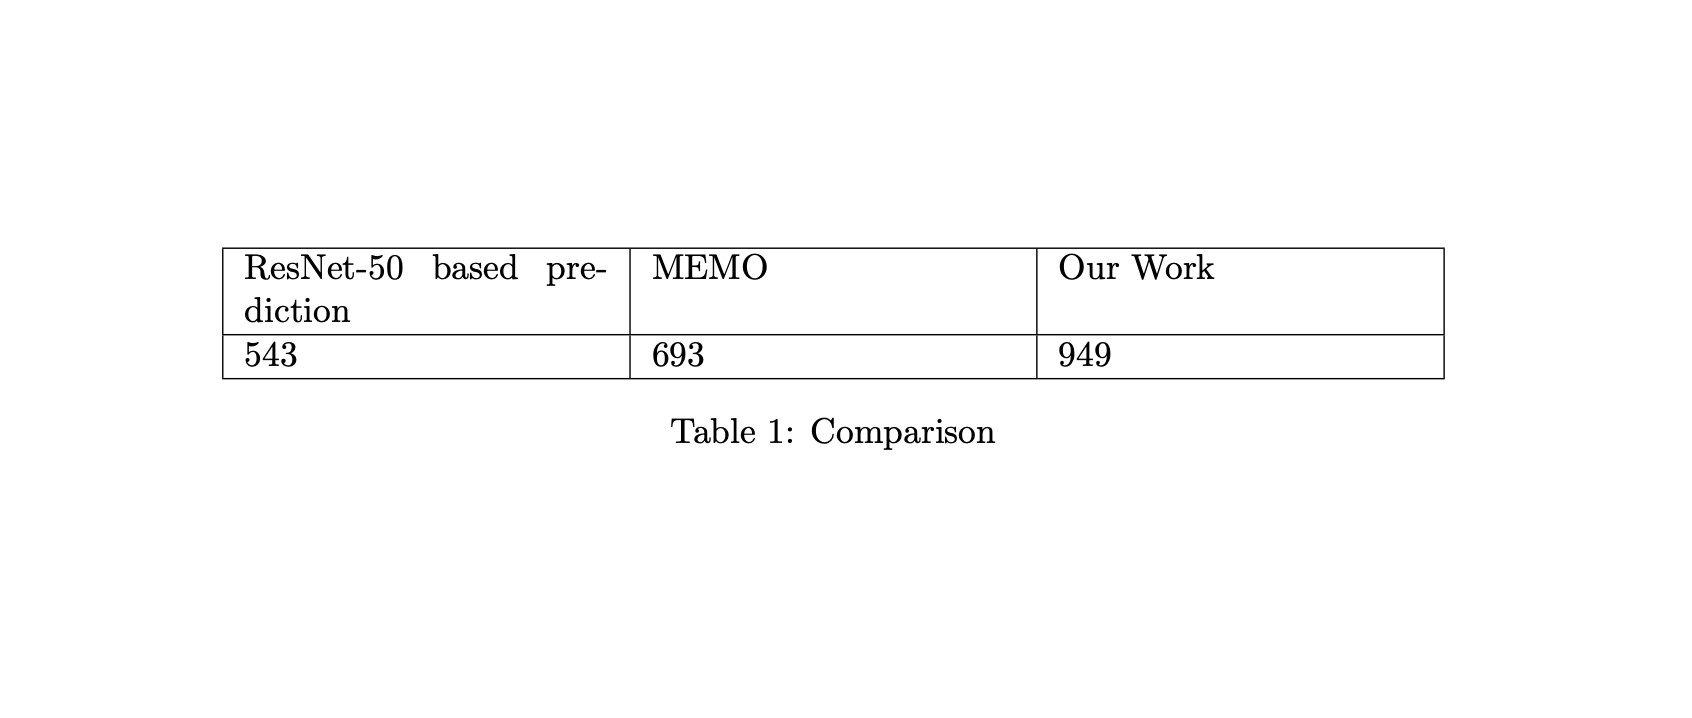

# failed experiments

## experiments on augmentations



1.   The idea was to develop a new method to generate the augmentations: divide the original image into patches, apply a different augmentation to each patch and finally reconstruct the original image.
This method did not bring any improvement over MEMO's baseline, either by creating all 64 augmentations with the *augment_image_in_patches* function, or by creating 32 augmentations with *augmix* and the remainder with *augment_image_in_patches*.




In [ ]:
from PIL import Image
import random
import numpy as np
import torch

def augment_image_in_patches(image_path, augmentations, num_patches=4):
    # Open the image and convert to RGB
    x_orig = Image.open(image_path).convert("RGB")
    # Apply pre-augmentation transformations
    image = preaugment(x_orig)

    # Get the dimensions of the image
    width, height = image.size

    # Calculate the size of each patch
    patch_size_w = width // num_patches
    patch_size_h = height // num_patches

    # Calculate the remainder to handle non-divisible dimensions
    remainder_w = width % num_patches
    remainder_h = height % num_patches

    patches = []
    # Divide the image into patches
    for i in range(num_patches):
        for j in range(num_patches):
            extra_w = 1 if j < remainder_w else 0
            extra_h = 1 if i < remainder_h else 0

            left = j * patch_size_w + min(j, remainder_w)
            upper = i * patch_size_h + min(i, remainder_h)
            right = left + patch_size_w + extra_w
            lower = upper + patch_size_h + extra_h

            box = (left, upper, right, lower)
            patch = image.crop(box)
            patches.append(patch)

    # Apply augmentations to all patches
    augmented_patches = []
    for patch in patches:
        augmentation = random.choice(augmentations)
        augmented_patch = augmentation(patch)
        augmented_patches.append(augmented_patch)

    # Recompose the augmented patches into a single image
    new_image = Image.new('RGB', (width, height))
    for idx, patch in enumerate(augmented_patches):
        i = idx // num_patches
        j = idx % num_patches

        extra_w = 1 if j < remainder_w else 0
        extra_h = 1 if i < remainder_h else 0

        left = j * patch_size_w + min(j, remainder_w)
        upper = i * patch_size_h + min(i, remainder_h)
        new_image.paste(patch, (left, upper))

    # Convert the PIL image to a NumPy array and change the shape from (H, W, C) to (C, H, W)
    new_array = np.array(new_image).transpose(2, 0, 1)

    # Scale the values from [0, 255] to [-1, 1]
    new_array = new_array.astype(np.float32) / 127.5 - 1

    # Convert the NumPy array to a PyTorch tensor
    new_tensor = torch.tensor(new_array)

    return new_tensor




2. implement others augmentations: we tried to implement other augmentations bases and either apply those directly without using augmix or use them as a basis for augmix (and also for the function described above: augment_image_in_patches) but did not obtain significant results


In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import cv2
import os
from torchvision import transforms
from scipy.ndimage import map_coordinates

# Define custom transformations
class Identity:
    def __call__(self, img):
        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'

class RandomPixelDropout:
    def __init__(self, probability=0.05):
        self.probability = probability

    def __call__(self, img):
        img_np = np.array(img)
        mask = np.random.rand(*img_np.shape[:2]) < self.probability
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        img_np[mask] = 0
        return Image.fromarray(img_np)

    def __repr__(self):
        return self.__class__.__name__ + '(probability={})'.format(self.probability)

class CutOut:
    def __init__(self, num_holes=1, hole_size_percent=0.4):
        self.num_holes = num_holes
        self.hole_size_percent = hole_size_percent

    def __call__(self, img):
        img_np = np.array(img)
        h, w, _ = img_np.shape
        hole_size = int(self.hole_size_percent * min(h, w))
        mean_value = img_np.mean(axis=(0, 1), dtype=int)

        for _ in range(self.num_holes):
            x = np.random.randint(0, w - hole_size)
            y = np.random.randint(0, h - hole_size)
            img_np[y:y + hole_size, x:x + hole_size, :] = mean_value

        return Image.fromarray(img_np)

    def __repr__(self):
        return self.__class__.__name__ + '(num_holes={}, hole_size_percent={})'.format(self.num_holes, self.hole_size_percent)

class SobelFilter:
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = np.array(img)
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, self.kernel_size)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, self.kernel_size)
        sobel = np.hypot(sobelx, sobely)
        if np.max(sobel) == 0:
            sobel = np.zeros_like(sobel)
        else:
            sobel = np.uint8(sobel / np.max(sobel) * 255)
        sobel_img = Image.fromarray(sobel)
        return sobel_img

class RandomGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError(f"Expected PIL.Image, got {type(img)}")

        img_np = np.array(img) / 255.0
        noise = np.random.normal(self.mean, self.std, img_np.shape)
        img_np = np.clip(img_np + noise, 0, 1) * 255
        return Image.fromarray(img_np.astype(np.uint8))

    def __repr__(self):
        return self.__class__.__name__ + '(mean={}, std={})'.format(self.mean, self.std)

class RandomElasticTransform:
    def __init__(self, alpha=1, sigma=0.1):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, img):
        img_np = np.array(img)
        shape = img_np.shape
        dx = np.random.uniform(-1, 1, shape[:2]) * self.alpha
        dy = np.random.uniform(-1, 1, shape[:2]) * self.alpha
        dz = np.zeros_like(dx)
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        distorted_image = np.empty_like(img_np)
        for i in range(shape[2]):
            distorted_image[:, :, i] = map_coordinates(img_np[:, :, i], indices, order=1, mode='reflect').reshape(shape[:2])
        return Image.fromarray(distorted_image.astype(np.uint8))

    def __repr__(self):
        return self.__class__.__name__ + '(alpha={}, sigma={})'.format(self.alpha, self.sigma)

# Add more augmentations here as needed

augmentations_to_skip = 0

augmentations = np.array([
    v2.RandomHorizontalFlip(p=1),
    v2.RandomVerticalFlip(p=1),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.RandomAffine(degrees=30, translate=(0.1, 0.1), shear=10),
    v2.RandomAdjustSharpness(sharpness_factor=2, p=1),
    v2.RandomAutocontrast(p=1),
    v2.RandomEqualize(p=1),
    v2.RandomPosterize(bits=4, p=1),
    v2.RandomSolarize(threshold=192.0, p=1),
    v2.RandomGrayscale(p=1),
    v2.GaussianBlur(kernel_size=5),
    v2.RandomPerspective(distortion_scale=0.5, p=1),
    v2.RandomInvert(p=1),
    RandomPixelDropout(probability=0.05),
    CutOut(num_holes=1, hole_size_percent=0.4),
    SobelFilter(kernel_size=5),
    RandomGaussianNoise(mean=0.0, std=0.1),
    RandomElasticTransform(alpha=1, sigma=0.1)
])

captions = np.array([
    "Horizontal Flip",
    "Vertical Flip",
    "Color Jitter",
    "Rotation",
    "Resized Crop",
    "Affine",
    "Adjust Sharpness",
    "Autocontrast",
    "Equalize",
    "Posterize",
    "Solarize",
    "Grayscale",
    "Gaussian Blur",
    "Perspective",
    "Negative",
    "Pixel Dropout",
    "CutOut",
    "Sobel Filter",
    "Random Gaussian Noise",
    "Elastic Transform"
])

probabilities = [
    0.50,  # probability for RandomHorizontalFlip
    0.50,  # probability for RandomVerticalFlip
    0.50,  # probability for ColorJitter
    0.50,  # probability for RandomRotation
    0.50,  # probability for RandomResizedCrop
    0.50,  # probability for RandomAffine
    0.50,  # probability for RandomAdjustSharpness
    0.50,  # probability for RandomAutocontrast
    0.50,  # probability for RandomEqualize
    0.50,  # probability for RandomPosterize
    0.50,  # probability for RandomSolarize
    0.50,  # probability for RandomGrayscale
    0.50,  # probability for GaussianBlur
    0.50,  # probability for RandomPerspective
    0.50,  # probability for RandomInvert
    0.50,  # probability for RandomPixelDropout
    0.50,  # probability for CutOut
    0.50,  # probability for SobelFilter
    0.50,  # probability for RandomGaussianNoise
    0.50   # probability for RandomElasticTransform
]

# Now you can use this augmented pipeline

## experiments on the architecture

### 1. teacher student

The initial idea was to apply a teacher-student architecture in which both teacher and student models were ResNet50. Several versions of this architecture were implemented, but none led to satisfactory results.

For each image, the general idea was to generate two augmented versions of the same image. One version was evaluated by the teacher and the other by the student. Subsequently, a loss was calculated to assess the similarity between the outputs of the two models. Using this loss, the weights of the student model were updated using a moving average with a parameter α (several configurations were tried for α). This process was repeated 32 times (so that 64 augmentations were applied) and finally the teacher weights were updated (again using a moving average) and the original image was tested on the teacher.

Another approach taken was to directly create two vectors of augmentations, each containing 32 augmentations of the original image. One vector was given as input to the teacher and the other to the student. The loss was calculated and finally a single parameter update step was performed.

Ways to compute the loss function

1.  **KL Divergence**: Use KL divergence as the loss to assess the similarity between the probability distributions output by the two models.
2. **KL Divergence with Cosine Similarity**: Use KL divergence in combination with cosine similarity between the heat maps provided by the two models (using GradCAM).



Here the main functions used for the teacher student architecture:

In [ ]:
def initialize_moving_average(model):
    """
    Create a dictionary to maintain the moving average of the model weights.

    Parameters:
    - model (torch.nn.Module): The model from which to extract the initial weights.

    Returns:
    - moving_avg_weights (dict): Dictionary containing the initial cloned and detached weights.
    """
    moving_avg_weights = {}
    for name, param in model.state_dict().items():
        moving_avg_weights[name] = param.clone().detach()
    return moving_avg_weights

def update_moving_average(moving_avg_weights, model, alpha=0.1):
    """
    Update the moving average of the model weights.

    Parameters:
    - moving_avg_weights (dict): Dictionary containing the current moving averaged weights.
    - model (torch.nn.Module): The model from which to extract the current weights.
    - alpha (float): Smoothing factor for the moving average (default is 0.1).
    """
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        # Ensure the parameter is a floating point tensor before performing lerp_
        if param.dtype.is_floating_point:
            if name in moving_avg_weights:
                # Perform the linear interpolation in-place
                moving_avg_weights[name].lerp_(param.data, alpha)
            else:
                # Initialize the parameter if it's not already in the dictionary
                moving_avg_weights[name] = param.clone().detach()
        else:
            # For non-floating point tensors, simply copy the current values if not already in the dictionary
            if name not in moving_avg_weights:
                moving_avg_weights[name] = param.clone().detach()

In [ ]:
def kl_divergence(logits_p, logits_q):
    """
    Calculate the Kullback-Leibler (KL) divergence between two sets of logits.

    Parameters:
    - logits_p (torch.Tensor): Logits from the first distribution.
    - logits_q (torch.Tensor): Logits from the second distribution.

    Returns:
    - torch.Tensor: The KL divergence between the two distributions.
    """
    # Convert logits to log-probabilities
    log_probs_p = F.log_softmax(logits_p, dim=-1)
    # Convert logits to probabilities for the second argument
    probs_q = F.softmax(logits_q, dim=-1)
    # Calculate the KL divergence
    return F.kl_div(log_probs_p, probs_q, reduction='batchmean')

In [ ]:
def compute_grad_cam(features, grads):
    """
    Compute the Grad-CAM (Gradient-weighted Class Activation Mapping) for the given features and gradients.

    Parameters:
    - features (torch.Tensor): Feature maps from a convolutional layer.
    - grads (torch.Tensor): Gradients of the output with respect to the feature maps.

    Returns:
    - torch.Tensor: The computed Grad-CAM heatmap.
    """
    # Compute the weights by averaging the gradients along the spatial dimensions
    weights = torch.mean(grads, dim=[2, 3], keepdim=True)
    # Compute the weighted sum of the feature maps
    grad_cam = torch.sum(weights * features, dim=1).squeeze().cpu()
    # Apply ReLU to the Grad-CAM heatmap
    grad_cam = F.relu(grad_cam)
    # Normalize the Grad-CAM heatmap to the range [0, 1]
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
    return grad_cam

def gradient_similarity(grads1, grads2):
    """
    Compute the similarity between two sets of gradients.

    Parameters:
    - grads1 (torch.Tensor): First set of gradients.
    - grads2 (torch.Tensor): Second set of gradients.

    Returns:
    - torch.Tensor: The gradient similarity loss (higher is worse).
    """
    # Calculate the cosine similarity between the flattened gradients
    similarity = F.cosine_similarity(grads1.view(-1), grads2.view(-1), dim=0)
    # Convert similarity to a loss (higher is worse)
    return 1 - similarity

### 2. generative methods

The basic idea was to create a simplified version of the input image and then apply augmentations to the simplified image, use marginal entropy to update the model weights and finally test the updated model using the original image. Two different methods were devised for generating the simplified image:

1. **Using Blip**: The first idea was to use Blip to generate a description of the input image. Then, another generative model would take this prompt provided by Blip and generate a new image based on the description.

2. **Generative Template with Specific Prompt**: The second idea was to use a generative model that would take the original image as input along with a specific prompt (e.g. "create a simplified version of the image") and output a simplified version of the image.

Both ideas did not lead to the desired results.


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
# Load the BLIP image captioning model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
# Function to visualize images
def print_images(images, indici):
    mean = torch.tensor(feature_extractor.image_mean).view(3, 1, 1)
    std = torch.tensor(feature_extractor.image_std).view(3, 1, 1)

    fig, axs = plt.subplots(1, len(images), figsize=(50, 50))
    if len(images) == 1:
        axs = [axs]
    for i, img in enumerate(images):
        img = img * std + mean  # Reverse normalization
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for proper display
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(captions[indici[i]], fontsize=6)
    plt.show()

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import tqdm

first = True

# Initialize the progress bar
pbar = tqdm.tqdm(total=7500)

# Iterate through the images in the directory
for cartella in os.listdir("imagenet-a"):
    cartella_path = os.path.join("imagenet-a", cartella)
    if os.path.isdir(cartella_path):  # Check if it's a directory
        # Assuming the directory contains images directly, adjust if there are subdirectories
        for image_file in os.listdir(cartella_path):
            image_path = os.path.join(cartella_path, image_file)

            try:
                # Open the image using PIL
                image = Image.open(image_path).convert('RGB')

                # Convert the image to a numpy array and normalize to [0, 1]
                image_np = np.array(image).astype(np.float32) / 255.0

                # Log the shape and dtype for debugging
                print(f"Processing image: {image_path}, shape: {image_np.shape}, dtype: {image_np.dtype}")

                # Ensure the image is in the format (height, width, channels)
                if image_np.ndim == 2:  # If the image is grayscale
                    image_np = np.stack((image_np,) * 3, axis=-1)
                elif image_np.shape[2] == 1:  # If the image has a single channel
                    image_np = np.squeeze(image_np, axis=2)
                    image_np = np.stack((image_np,) * 3, axis=-1)

                # Verify the image data type is uint8 before converting back to PIL image
                image_np_uint8 = (image_np * 255).astype(np.uint8)

                # Convert the normalized numpy array back to a PIL image
                image = Image.fromarray(image_np_uint8)

                # Pre-process the image using the processor
                inputs = processor(images=image, return_tensors="pt")

                # Generate the caption using the model
                out = model_blip.generate(**inputs)
                caption = processor.decode(out[0], skip_special_tokens=True)

                # Print the generated caption
                print("Didascalia generata:", caption)

                # Update the progress bar
                pbar.update(1)
                processed_images += 1

                # Check if we have processed the required number of images
                if processed_images >= max_images:
                    break

            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                continue

        # Check again to break the outer loop if the limit is reached
        if processed_images >= max_images:
            break

pbar.close()


In [ ]:
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import clip

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to download and preprocess the input image
def download_and_preprocess_image(url):
    response = requests.get(url)
    input_image = Image.open(BytesIO(response.content)).convert("RGB")
    input_image = preprocess(input_image).unsqueeze(0).to(device)
    return input_image

# Function to generate the image with VQGAN+CLIP
def generate_image(input_image, prompt):
    # Placeholder for VQGAN+CLIP image generation code
    # This function returns the input image for simplicity
    return input_image

# Download an example input image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image.png"
input_image = download_and_preprocess_image(url)

# Define the text prompt
prompt = "A simplified and stylized version of the input image."

# Generate the image
output_image = generate_image(input_image, prompt)

# Convert the output image to a displayable format
output_image = TF.to_pil_image(output_image.squeeze(0).cpu())

# Display the generated image
plt.imshow(output_image)
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import tqdm
from PIL import Image
import requests
import torchvision

first = True

# Initialize the progress bar
pbar = tqdm.tqdm(range(len(dataset)))

# Iterate over the dataset
for i in pbar:
    image, labels = dataset[i]

    # Resize the input image
    input_image = torchvision.transforms.functional.resize(image, (512, 512))

    # Define the text prompt
    prompt = "a cat is sitting in a blue box"

    # Generate the image using the pipe
    output = pipe(prompt=[prompt], image=[input_image]).images[0]

    if first:
        first = False
        # Store the first image in the CPU for printing
        images_cpu = [input_image.cpu()]
        print_images(images_cpu, [1])

        # Display the generated image
        plt.imshow(output)
        plt.axis('off')  # Hide the axes
        plt.show()


### Failure Analysis

1. One of the main reasons why the **augmented image patches** technique failed to improve performance is that it introduced inconsistencies and artifacts, which hindered the model's learning process. By dividing the original image into patches, applying different augmentations to each patch, and then reconstructing the original image, this method caused discontinuities at the patch boundaries. These discontinuities negatively impacted the model’s ability to learn effectively. Another critical issue was the use of a mix of augmentation techniques without a cohesive strategy. This led to an overall noisy augmentation process, with the augmented images having varying levels of distortions. Consequently, the model struggled to maintain the integrity of the visual information across the patches. This inconsistency was evident in the loss curves, which showed no significant improvement over MEMO's baseline, indicating that the model could not adapt to the augmented data effectively. Moreover, implementing other augmentation bases without using AugMix, or using them as a basis for AugMix, did not yield significant results. This suggests that merely combining multiple augmentation techniques without a well-defined strategy does not necessarily enhance the model's robustness or performance. Another significant factor was the computational overhead introduced by this method. Dividing an image into patches and applying different augmentations to each patch is computationally intensive, which slowed down the training process and made the approach impractical for real-time or large-scale applications.

2.  One of the main reasons why the **teacher-student** architecture may not have worked is that the reference teacher model was not good enough. If the teacher model does not perform well, the student model, which fits the teacher, will inevitably inherit its limitations. This problem is highlighted by the fact that the loss analysis did not show a significant decrease during the iterations, indicating that the student was not improving its performance by adapting to the teacher. Another critical factor is the importance of comparing the probability distributions of the two models. It is not so important that the probability distributions of the models are similar, but that their top predictions (i.e. the classes predicted with the highest probability) are the same, so the loss used to compare the teacher and student models may not have been adequate.
Another problem is that, by always using different augmentations of the image, the stability of the model during the test time is compromised as the teacher model is unstable and subject to fluctuations in its predictions, consequently the student will fail to converge to an optimal solution.

3. One of the main problems in using Blip and **generative models** was the inability to capture the essence of complex images. The descriptions generated by Blip often did not accurately represent the content of the original image. As a result, the images generated on the basis of these descriptions were very different from the original and did not correctly represent the necessary visual information. Even when a generative model with a specific prompt was used to simplify the image, the output often failed to retain the relevant features of the original image. This led to simplified images that did not adequately represent the visual content of the input, compromising the effectiveness of augmentations applied later. Complex images with many details and unique features were particularly problematic. Generative models tended to lose important details during the simplification process, resulting in images that could not be used effectively for model training. The use of generative models has led to a significant slowdown in the overall process. The generation of simplified images requires significant computational resources and time, which makes the approach impractical for real-time or large-scale applications. This slowdown further complicated the successful implementation of test time adaptation.